---
### Smart Optimization to Save Computing Time
---

#### I. Load model and data

In [1]:
import pickle

In [2]:
with open('models/model_dt_regression.pkl', 'rb') as f:
    model_dt = pickle.load(f)

In [3]:
model_dt

DecisionTreeRegressor(max_depth=15)

In [4]:
import pandas as pd

df = pd.read_excel('data/Microsoft_LinkedIn_Processed.xlsx', index_col=0, parse_dates=['Date'])
df.head(n=5)

,Close,High,Low,Open,Volume,change_tomorrow,change_tomorrow_direction
Date,,,,,,,
2016-12-08,55.181126,55.696671,55.027369,55.443420,21220800,1.549151,UP
2016-12-09,56.049416,56.067505,55.289669,55.334891,27349400,0.321666,UP
2016-12-12,56.230289,56.347870,55.823285,55.913730,20198100,1.286169,UP
2016-12-13,56.962929,57.360890,56.293630,56.528788,35718900,-0.478644,DOWN
2016-12-14,56.691578,57.388013,56.555907,56.981005,30352700,-0.159789,DOWN


---
#### II. Parametrize & optimize the investment strategy

Create Strategy class.

In [6]:
from backtesting import Strategy

In [7]:
class Regression(Strategy):
    limit_buy = 1
    limit_sell = -5
    
    def init(self):
        self.model = model_dt
        self.already_bought = False

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :]
        forecast_tomorrow = self.model.predict(explanatory_today)[0]
        
        if forecast_tomorrow > self.limit_buy and self.already_bought == False:
            self.buy()
            self.already_bought = True
        elif forecast_tomorrow < self.limit_sell and self.already_bought == True:
            self.sell()
            self.already_bought = False
        else:
            pass

Create `Backtest` class.

In [8]:
from backtesting import Backtest

In [9]:
df_explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

bt = Backtest(df_explanatory, Regression,
              cash=10000, commission=.002, exclusive_orders=True)

Optimize backtesting with multiple combinations.

In [10]:
from skopt import gp_minimize
from skopt.space import Integer
from collections import defaultdict

In [11]:
# Step 1: Create dictionary to store results
results_dict = defaultdict(float)

# Step 2: Define the objective function
def objective(params):
    buy, sell = params
    Regression.limit_buy = buy
    Regression.limit_sell = sell

    stats = bt.run()
    ret = stats['Return [%]']
    
    results_dict[(buy, sell)] = ret  # Store result
    return -ret                      # gp_minimize minimizes, so we negate the return
       
# Step 3: Define search space and run optimization
search_space = [
    Integer(0, 10, name='limit_buy'),
    Integer(-10, 0, name='limit_sell')
]

optimize_result = gp_minimize(
    objective,
    search_space,
    n_calls=50,
    random_state=0
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/backtesting/_stats.py:155: RuntimeWarning: divide by zero encountered in log
  equity_log_returns = np.log(equity[1:] / equity[:-1])
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has bee

*Which are the best values for the parameters?*

In [19]:
import numpy as np

In [20]:
# Step 4: Convert stored results to a DataFrame
df = pd.DataFrame([
    {'limit_buy': buy, 'limit_sell': sell, 'Return [%]': ret}
    for (buy, sell), ret in results_dict.items()
])

# Step 5: Pivot the DataFrame to form a heatmap-style table
dff = df.pivot(index='limit_buy', columns='limit_sell', values='Return [%]')

# Step 6: Display heatmap with gradient
dff.sort_index(axis=1, ascending=False)\
   .style.format(precision=0)\
   .background_gradient(vmin=np.nanmin(dff.values), vmax=np.nanmax(dff.values))\
   .highlight_null(props='background-color: transparent; color: transparent')

limit_sell,0,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10
limit_buy,,,,,,,,,,,
0,21293,15789,3835,nan,nan,nan,nan,nan,nan,nan,535
1,316,1161,nan,1224,888,nan,nan,531,nan,nan,453
2,nan,121,nan,194,nan,nan,nan,nan,nan,nan,341
3,nan,-73,nan,-74,-82,62,208,nan,nan,341,nan
4,-77,nan,-78,nan,nan,nan,nan,nan,94,255,nan
5,nan,nan,-79,nan,-88,nan,nan,nan,94,nan,nan
6,nan,nan,-100,nan,nan,nan,33,10,22,nan,nan
8,nan,nan,-100,nan,nan,-100,-100,nan,nan,nan,nan
9,nan,nan,-100,nan,nan,-100,nan,nan,-100,-100,nan


---
#### III. How to interpret smart optimization?

Number of evaluations. Check `Parameter Heatmap`: https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap%20&%20Optimization.html.

In [13]:
from skopt.plots import plot_evaluations

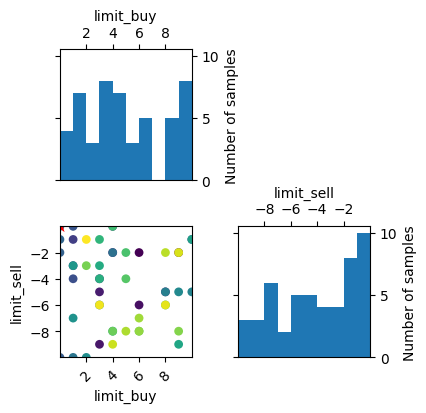

In [14]:
_ = plot_evaluations(optimize_result, bins=10)

Density.

In [16]:
from skopt.plots import plot_objective

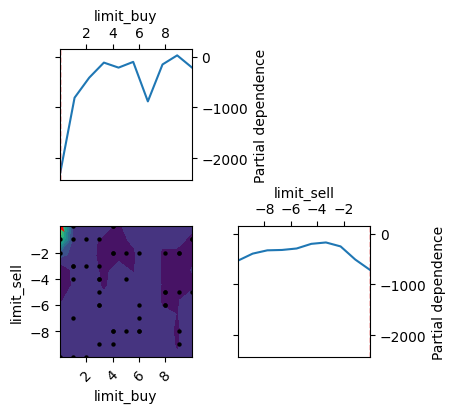

In [17]:
_ = plot_objective(optimize_result, n_points=10)